## Using keras on MNIST dataset for image processing

### Lets start by importing the stuff we need, including the new layer types 

In [2]:
import tensorflow 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop


##Loading of the mnist data

In [3]:
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


#### The next things is to shape the data differently, since we're treating the data as 2D images of 28 X 28 pixels instead of a flattened stream of 784 pixels. we need to shape it accordingly Depending on the data format keras is set up for this may be 1 x 28 x 28 or 28 x 28 x 1 the 1's indicates a single color channel as this is just grayscale if we were dealing with color images it would be 3 instead of 1 since we'd have red green and blue color channels)

In [4]:
from tensorflow.keras import backend as k

if k.image_data_format() == "channels_first":
  train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 1, 28, 28)
  test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28)
  input_shape = (1, 28, 28)
else:
  train_images = mnist_train_images.reshape(mnist_train_images.shape[0], 28, 28, 1)
  test_images = mnist_test_images.reshape(mnist_test_images.shape[0], 28, 28, 1)
  input_shape = (28, 28, 1)

  train_images = train_images.astype("float32")
  test_images = test_images.astype("float32")
  train_images /= 255
  test_images /= 255

## I need to convert the train and test labels to be categorical in one-hot format

In [5]:
train_labels = tensorflow.keras.utils.to_categorical(mnist_train_labels, 10)
test_labels = tensorflow.keras.utils.to_categorical(mnist_test_labels, 10)

## As a sanity check let's print out one of the training images with its label

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


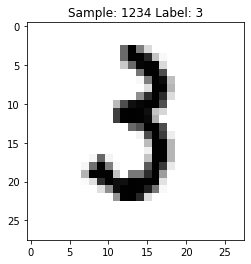

In [6]:
import matplotlib.pyplot as plt


def display_sample(num):
  #print the one-hot array of this sample's label
  print(train_labels[num])
  #print the label converted back to a number
  label = train_labels[num].argmax(axis=0)
  #Reshape the 768 values to a 28X28 image
  image = train_images[num].reshape([28, 28])
  plt.title("Sample: %d Label: %d" %(num, label))
  plt.imshow(image, cmap=plt.get_cmap("gray_r"))
  plt.show()

display_sample(1234)


### Now for the meat of the problem. setting up a convolutional neural network involues more layers. Not all of these are strickly necessary, we could run the cell without  pooling and dropout, but those extra steps help avoid overfitting and help things run faster
### we'll start with a 2D convolution of the image-it's set up to take 32 windows, or "filters", of each image, each filter being 3 X 3 in size
### we then run a second convolution on top of that with 64 3X3 windows-this topology is just what comes recommended with keras's own examples. Again we want to re-use previous research whenever possible while tuning CNN's as it is hard to do
### Next we apply a Maxpooling2D layer that takes the maximum of each 2X2 result to distill the results down into something more manageable
### A dropout filter is then applied to prevent overfitting
### Next we flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron
### ....and feed that into a hidden, flat layer of 128units
### We then apply dropout again to further prevent overfitting
### And finally, we feed that into our final 10 units where softmax is apllied to choose our category of 0-9 

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                 activation="relu",
                 input_shape=input_shape))
# 64 3 X 3 kernels
model.add(Conv2D(64, (3,3), activation="relu"))
# Reduce by taking the max of each 2 X 2 block
model.add(MaxPooling2D(pool_size=(2,2)))
#Dropout to avoid overfitting
model.add(Dropout(0.25))
#Flatten the results to one dimention for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation="relu"))
# Another dropout
model.add(Dropout(0.5))
#Final categorization from 0-9 with softmax
model.add(Dense(10, activation="softmax"))

## Checking the model description

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0         
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                      

## We are still doing multiple categorization, so categorical_crossentropy is still the right loss function to use. we'll use the adam optimizer, although the example provided with keras uses RMSprop. we might want to try both if we have time 

In [10]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

### And now we train our model... to make things go a little faster, we'll use batches of 32
# Warning
### This could take hours to run and computer's CPU will be maxed out during that time! Don't run the next block unless one can tie up computer for a long time. it will print progress as each epoch is run, but each epoch can take around 20 minutes 


In [12]:
history = model.fit(train_images, train_labels,
                    batch_size=32,
                    epochs=10,
                    verbose=2,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 - 210s - loss: 0.0212 - accuracy: 0.9931 - val_loss: 0.0368 - val_accuracy: 0.9909 - 210s/epoch - 112ms/step
Epoch 2/10
1875/1875 - 233s - loss: 0.0198 - accuracy: 0.9939 - val_loss: 0.0331 - val_accuracy: 0.9917 - 233s/epoch - 124ms/step
Epoch 3/10
1875/1875 - 150s - loss: 0.0185 - accuracy: 0.9940 - val_loss: 0.0363 - val_accuracy: 0.9919 - 150s/epoch - 80ms/step
Epoch 4/10
1875/1875 - 147s - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0365 - val_accuracy: 0.9917 - 147s/epoch - 79ms/step
Epoch 5/10
1875/1875 - 149s - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0325 - val_accuracy: 0.9922 - 149s/epoch - 79ms/step
Epoch 6/10
1875/1875 - 148s - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0343 - val_accuracy: 0.9932 - 148s/epoch - 79ms/step
Epoch 7/10
1875/1875 - 148s - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.0343 - val_accuracy: 0.9924 - 148s/epoch - 79ms/step
Epoch 8/10
1875/1875 - 147s - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.0388 - val_accuracy

## The result is actually cool

In [14]:
score = model.evaluate(test_images, test_labels, verbose=0)
print("Test lost: ", score[0])
print("Test accuracy: ", score[1])

Test lost:  0.036077726632356644
Test accuracy:  0.9918000102043152


### Over 99% with just 10 epochs! it came at a significant cost in terms of computing power, but when we start distributing things over multiple computers each with multiple GPU's that cost starts to feel less bad. If you're building something where life and death are on the line like a self-driving car.
### Every fraction of a percent matters
